Imports

In [1]:
from utils.preprocessing import add_metadata, concat_data, parse_fasta_with_groups, prepare_contrasted_learning_data
from embeddings.protBERT import get_protbert_embeddings, contasted_learning
from utils.visualisation import draw_pca
from utils.model_training import split_train_test_virus_group
from Bio import SeqIO
import pandas as pd
import numpy as np
import os
from typing import List, Tuple
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\mateu\OneDrive\Pulpit\studia\ib\2 sem\protBERT wirusy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Normal ProtBERT parameters

In [2]:
NORMAL_MAX_SEQ_LEN = 1024
NORMAL_BATCH_SIZE = 4

Contrasted learning protBERT parameters

In [3]:
CL_EPOCHS = 10
CL_TRAIN_LIMIT_NH = 2000
CL_MAX_LEN = 600
CL_BATCH_SIZE = 16
CL_ACCUMULATION_STEPS = 2
CL_LR = 2e-5

Paths

In [4]:
human_raw_path = "data/raw/human_98.fasta"
nonhuman_raw_path = "data/raw/nonhuman_98.fasta"
normal_protbert_path = "data/processed/protbert.pkl"
contrased_learning_probert_path = "data/processed/contrasted_learning_protbert.pkl"
contrasted_learning_adapter_path = "model/contrastive_learning_adapter"

Generate embeddings preprocessing

In [5]:
pre_emb_human, metadata_human = parse_fasta_with_groups(human_raw_path, 1)
pre_emb_nonhuman, metadata_nonhuman = parse_fasta_with_groups(nonhuman_raw_path, 0)

Loaded 134 sequences from data/raw/human_98.fasta.'
Loaded 4507 sequences from data/raw/nonhuman_98.fasta.'


Generate normal protBERT embeddings


In [6]:
if os.path.exists(normal_protbert_path):
    print("Embedding were generated previously, skipping generating them.")
else:
    protbert_emb_human = get_protbert_embeddings(pre_emb_human, NORMAL_MAX_SEQ_LEN, NORMAL_BATCH_SIZE)
    protbert_emb_nonhuman = get_protbert_embeddings(
        pre_emb_nonhuman, NORMAL_MAX_SEQ_LEN, NORMAL_BATCH_SIZE
    )

    human_labeled = add_metadata(protbert_emb_human, metadata_human)
    nonhuman_labeled = add_metadata(protbert_emb_nonhuman, metadata_nonhuman)

    concat_data(human_labeled, nonhuman_labeled, out_path=normal_protbert_path)

Embedding were generated previously, skipping generating them.


Generate contrasted learning protBERT adapter

In [7]:
if os.path.exists(contrasted_learning_adapter_path):
    print("Adapter was pre-made, skipping generating it.")
else:
    all_seqs, all_labels = prepare_contrasted_learning_data(pre_emb_human, pre_emb_nonhuman, CL_TRAIN_LIMIT_NH)
    cl_adapter = contrasted_learning_adapter = contasted_learning(all_seqs,
                                                     all_labels,
                                                     CL_MAX_LEN,
                                                     CL_BATCH_SIZE,
                                                     CL_LR,
                                                     CL_EPOCHS,
                                                     CL_ACCUMULATION_STEPS,
                                                     contrasted_learning_adapter_path)

Adapter was pre-made, skipping generating it.


Generate contrasted learning protBERT embeddings

In [8]:
if os.path.exists(contrased_learning_probert_path):
    print("CL Embedding were generated previously, skipping generating them.")
else:
    protbert_emb_human = get_protbert_embeddings(pre_emb_human, NORMAL_MAX_SEQ_LEN, NORMAL_BATCH_SIZE, contrasted_learning_adapter_path)
    protbert_emb_nonhuman = get_protbert_embeddings(
        pre_emb_nonhuman, NORMAL_MAX_SEQ_LEN, NORMAL_BATCH_SIZE, contrasted_learning_adapter_path
    )

    human_labeled = add_metadata(protbert_emb_human, metadata_human)
    nonhuman_labeled = add_metadata(protbert_emb_nonhuman, metadata_nonhuman)

    concat_data(human_labeled, nonhuman_labeled, out_path=contrased_learning_probert_path)

CL Embedding were generated previously, skipping generating them.


Compare PCA (normal vs contrasted learning protBERT)

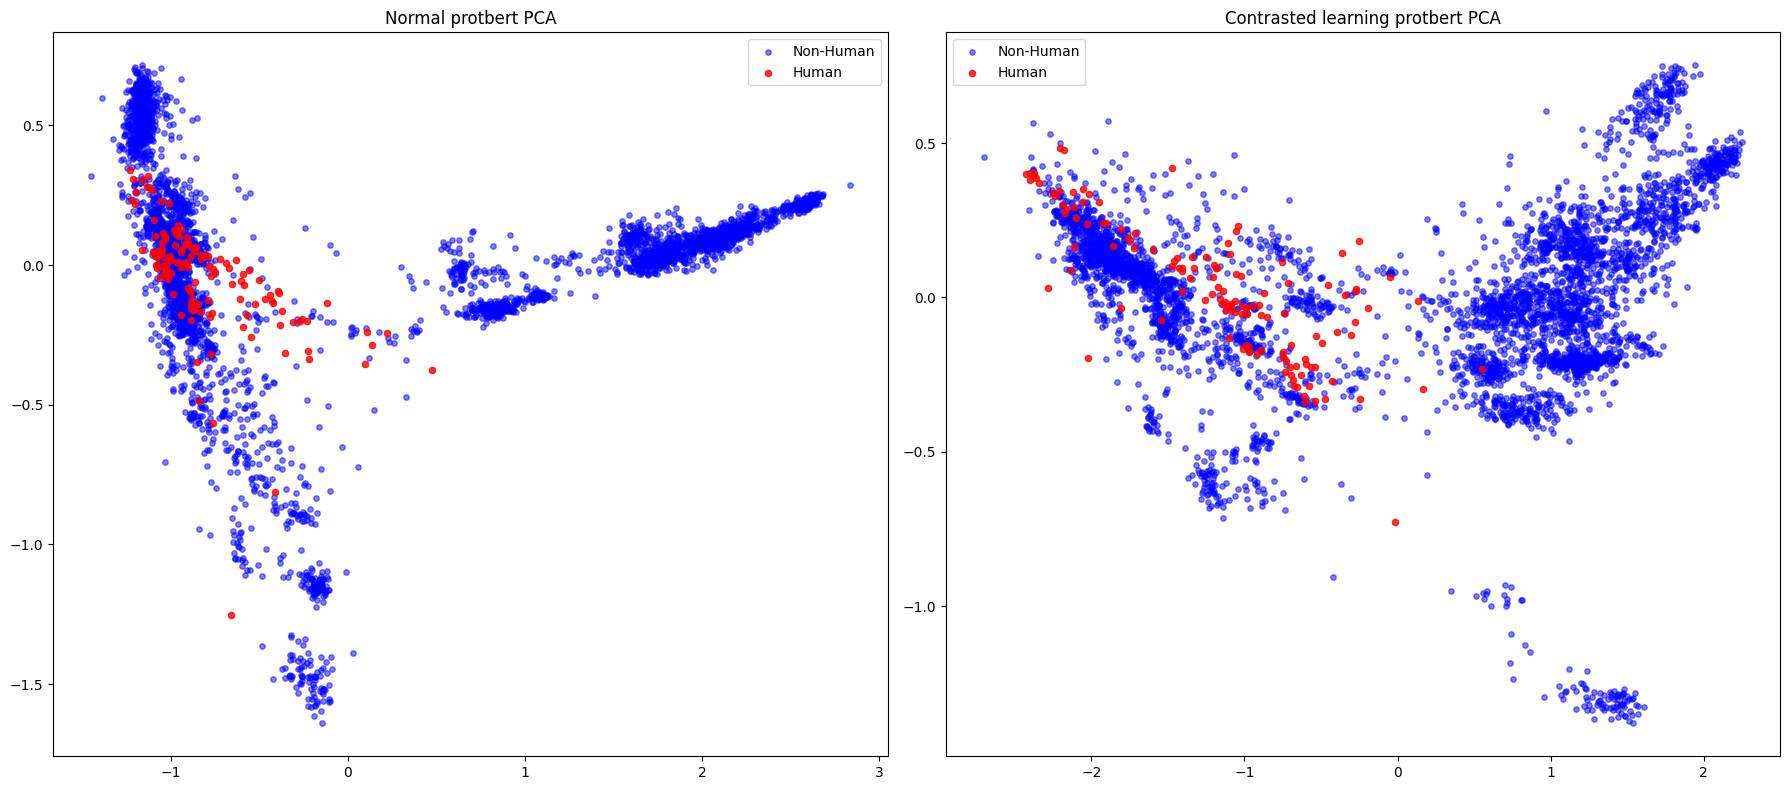

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
draw_pca(normal_protbert_path, "Normal protbert PCA", ax1)
draw_pca(contrased_learning_probert_path, "Contrasted learning protbert PCA", ax2)

plt.tight_layout()
plt.show()

Random forest - prepare data

In [10]:
normal_X_train, normal_y_train, normal_X_test, normal_y_test = split_train_test_virus_group(normal_protbert_path)
cl_X_train, cl_y_train, cl_X_test, cl_y_test = split_train_test_virus_group(contrased_learning_probert_path)

Random forest - normal protBERT

In [11]:
normal_model_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

normal_model_rf.fit(normal_X_train, normal_y_train)
normal_y_pred = normal_model_rf.predict(normal_X_test)

cm = confusion_matrix(normal_y_test, normal_y_pred)
report = classification_report(normal_y_test, normal_y_pred)

normal_results_path = "normal_results.txt"

with open(normal_results_path, "w", encoding="utf-8") as f:
    f.write("Confusion Matrix:\n")
    f.write(str(cm))
    f.write("\n===============================\n")
    f.write(report)

Random forest - Contrasted learning protBERT

In [12]:
cl_model_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

cl_model_rf.fit(cl_X_train, cl_y_train)
cl_y_pred = cl_model_rf.predict(cl_X_test)

cm = confusion_matrix(cl_y_test, cl_y_pred)
report = classification_report(cl_y_test, cl_y_pred)

cl_results_path = "cl_results.txt"

with open(cl_results_path, "w", encoding="utf-8") as f:
    f.write("Confusion Matrix:\n")
    f.write(str(cm))
    f.write("\n===============================\n")
    f.write(report)